<a href="https://colab.research.google.com/github/robledomeyli-spec/trabajo2_modelado_bcrp/blob/main/Trabajo_2_borrador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# %% [markdown]
# # Trabajo 2 – Modelado Lineal Supervisado: OLS simple vs múltiple
# **Curso:** Introducción a Ciencia de Datos y Machine Learning con Python  
# **Estudiante:** *[Tu nombre]*  
# **Fecha:** Octubre 2025
#
# ---
# ## 1. Recordatorio del dataset y pregunta de investigación
#
# Dataset: Índices empresariales mensuales (2015–...) con expectativas macroeconómicas y tipo de cambio.  
#
# **Variable dependiente (Y):** Situacion_Negocio  
# **Variables explicativas (X):** Expectativas_Demanda, Expectativas_Economia, Expectativas_Sector,
# Venta_Mes_Anterior, Tipo_Cambio_Compra  
#
# **Pregunta:**  
# > ¿Cómo influyen las expectativas macroeconómicas y el tipo de cambio en la percepción de la situación del negocio?
#
# Objetivo inferencial: analizar la magnitud y significancia estadística de los efectos de las expectativas sobre la percepción empresarial.


In [8]:
# %%cell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from statsmodels.stats.diagnostic import het_breuschpagan
import warnings
warnings.filterwarnings("ignore")

# Cargar el dataset limpio generado en el Trabajo 1
df = pd.read_csv("dataset_bcrp_corregido.csv", encoding="utf-8-sig")

# Verificar primeras filas
df.head()



,Fecha,Tipo_Cambio_Compra,Venta_Mes_Anterior,Situacion_Negocio,Expectativas_Demanda,Expectativas_Economia,Expectativas_Sector
0,2015-01-01,65.189873,50.949367,59.744409,70.727848,63.993711,3.0579
1,2015-02-01,60.534591,46.666667,58.878505,68.750000,62.264151,3.0928
2,2015-03-01,56.060606,50.923077,58.982036,67.125382,60.757576,3.0965
3,2015-04-01,55.539773,52.435530,59.295775,66.713881,61.538462,3.1263
4,2015-05-01,53.835227,52.556818,57.022472,66.242938,58.664773,3.1565


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Fecha                  127 non-null    object 
 1   Tipo_Cambio_Compra     127 non-null    float64
 2   Venta_Mes_Anterior     127 non-null    float64
 3   Situacion_Negocio      127 non-null    float64
 4   Expectativas_Demanda   127 non-null    float64
 5   Expectativas_Economia  127 non-null    float64
 6   Expectativas_Sector    127 non-null    float64
dtypes: float64(6), object(1)
memory usage: 7.1+ KB
None
Fecha                    0
Tipo_Cambio_Compra       0
Venta_Mes_Anterior       0
Situacion_Negocio        0
Expectativas_Demanda     0
Expectativas_Economia    0
Expectativas_Sector      0
dtype: int64


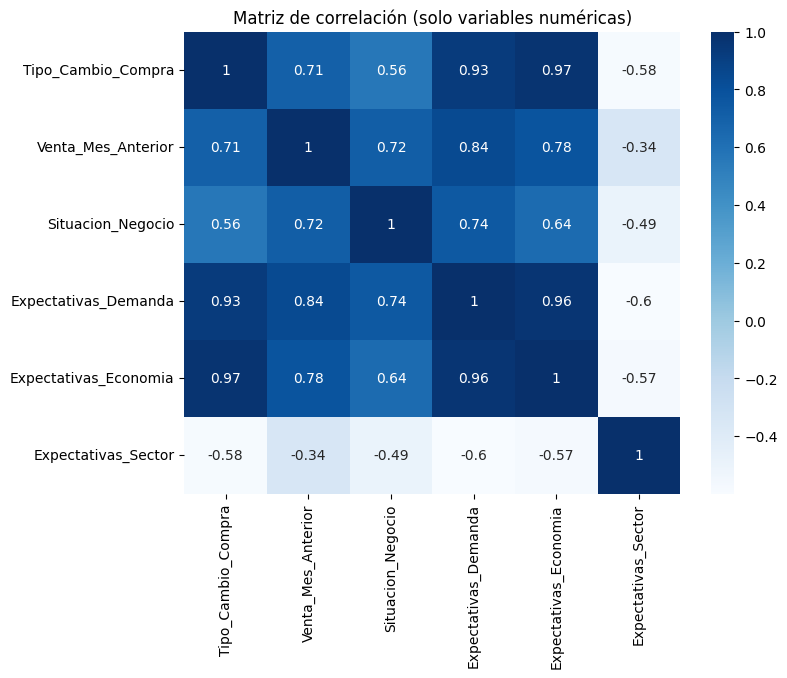

In [10]:
# %%cell
# Verificar tipos y NAs
print(df.info())
print(df.isna().sum())

# Eliminar o imputar si hay pocos NAs
df = df.dropna()

# Convertir columnas numéricas si alguna fue leída como texto
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = df[col].astype(float)
        except:
            pass

# Matriz de correlación (solo columnas numéricas)
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), annot=True, cmap="Blues")
plt.title("Matriz de correlación (solo variables numéricas)")
plt.show()



In [11]:
# %%cell
target = 'Situacion_Negocio'
features = ['Expectativas_Demanda', 'Expectativas_Economia',
            'Expectativas_Sector', 'Venta_Mes_Anterior', 'Tipo_Cambio_Compra']

X = df[features]
y = df[target]

print("Tamaño del dataset:", X.shape)


Tamaño del dataset: (127, 5)


In [12]:
# %%cell
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print("Training:", X_train.shape, "Test:", X_test.shape)


Training: (95, 5) Test: (32, 5)


Variable más correlacionada: Expectativas_Demanda
                            OLS Regression Results                            
Dep. Variable:      Situacion_Negocio   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     87.22
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           5.12e-15
Time:                        18:44:46   Log-Likelihood:                -280.86
No. Observations:                  95   AIC:                             565.7
Df Residuals:                      93   BIC:                             570.8
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

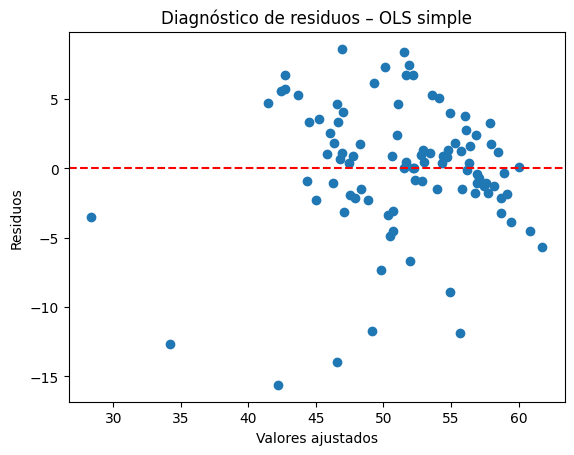

In [13]:
# %%cell
# Identificar la variable más correlacionada con la dependiente
corrs = X_train.corrwith(y_train).abs().sort_values(ascending=False)
top_pred = corrs.index[0]
print("Variable más correlacionada:", top_pred)

# Ajustar modelo simple con statsmodels
Xs = sm.add_constant(X_train[[top_pred]])
ols_simple = sm.OLS(y_train, Xs).fit(cov_type='HC1')
print(ols_simple.summary())

# Diagnóstico: residuos vs valores ajustados
plt.scatter(ols_simple.fittedvalues, ols_simple.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Diagnóstico de residuos – OLS simple")
plt.show()


                            OLS Regression Results                            
Dep. Variable:      Situacion_Negocio   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     48.38
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           6.14e-24
Time:                        18:45:19   Log-Likelihood:                -257.49
No. Observations:                  95   AIC:                             527.0
Df Residuals:                      89   BIC:                             542.3
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -10.35

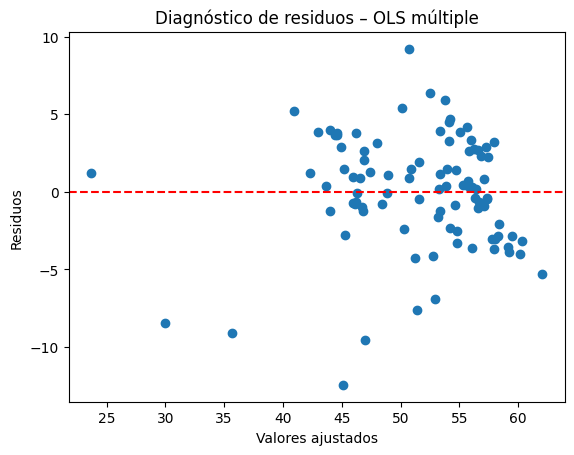

{'LM Stat': np.float64(11.399174936224354), 'LM p-value': np.float64(0.04401541363570035), 'F Stat': np.float64(2.4270731025681296), 'F p-value': np.float64(0.041263774463416954)}


In [14]:
# %%cell
Xm = sm.add_constant(X_train)
ols_multi = sm.OLS(y_train, Xm).fit(cov_type='HC1')
print(ols_multi.summary())

# Diagnóstico de residuos
plt.scatter(ols_multi.fittedvalues, ols_multi.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Diagnóstico de residuos – OLS múltiple")
plt.show()

# Prueba de heterocedasticidad Breusch–Pagan
bp_test = het_breuschpagan(ols_multi.resid, Xm)
labels = ['LM Stat','LM p-value','F Stat','F p-value']
print(dict(zip(labels, bp_test)))


In [15]:
# %%cell
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Modelo baseline (media)
dummy = DummyRegressor(strategy='mean')
baseline_mse = -cross_val_score(dummy, X_train, y_train,
                                cv=kf, scoring=mse_scorer).mean()

# Modelo simple
lr_simple = LinearRegression()
simple_mse = -cross_val_score(lr_simple, X_train[[top_pred]],
                              y_train, cv=kf, scoring=mse_scorer).mean()

# Modelo múltiple
lr_multi = LinearRegression()
multi_mse = -cross_val_score(lr_multi, X_train, y_train,
                             cv=kf, scoring=mse_scorer).mean()

print(f"MSE Baseline: {baseline_mse:.4f}")
print(f"MSE OLS Simple: {simple_mse:.4f}")
print(f"MSE OLS Múltiple: {multi_mse:.4f}")


MSE Baseline: 55.8543
MSE OLS Simple: 22.7523
MSE OLS Múltiple: 15.1458


In [16]:
# %%cell
lr_multi.fit(X_train, y_train)
y_pred_test = lr_multi.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE final en conjunto de test:", round(mse_test,4))


MSE final en conjunto de test: 23.0084
